In [1]:
from matplotlib import pyplot as plt
import numpy as np
from ase.io import read
from ase.build import make_supercell

In [13]:
class UnitCell:
    """
    Represents a unit cell defined by its POSCAR file. Handles the extraction
    of lattice vectors and their magnitudes.

    Attributes:
    -----------
    unit_cell : ASE Atoms object
        The atomic structure read from the POSCAR file.
    a1 : numpy.ndarray
        The first lattice vector (x, y components only).
    a2 : numpy.ndarray
        The second lattice vector (x, y components only).
    """

    def __init__(self, poscar_file):
        """
        Initializes the UnitCell object by reading the POSCAR file and extracting
        the lattice vectors.

        Parameters:
        -----------
        poscar_file : str
            Path to the POSCAR file containing the unit cell structure.
        """
        self.unit_cell = read(poscar_file)
        self.a1 = self.unit_cell.cell[0][:2]  # x, y components
        self.a2 = self.unit_cell.cell[1][:2]

    def get_lattice_vectors(self):
        """
        Returns the lattice vectors of the unit cell.

        Returns:
        --------
        a1, a2 : tuple of numpy.ndarray
            The first and second lattice vectors (x, y components only).
        """
        return self.a1, self.a2

    def get_magnitudes(self):
        """
        Returns the magnitudes of the lattice vectors.

        Returns:
        --------
        mag_a1, mag_a2 : tuple of float
            The magnitudes of the first and second lattice vectors.
        """
        return np.linalg.norm(self.a1), np.linalg.norm(self.a2)


class Supercell:
    """
    Represents a supercell created from a unit cell. Provides methods for
    checking commensurability and periodic boundary conditions (PBC).

    Attributes:
    -----------
    supercell : ASE Atoms object
        The atomic structure of the supercell.
    """

    def __init__(self, unit_cell, n1, n2):
        """
        Initializes the Supercell object by creating the supercell from the unit cell.

        Parameters:
        -----------
        unit_cell : UnitCell
            The UnitCell object representing the base unit cell.
        n1 : int
            The number of repetitions along the first lattice vector.
        n2 : int
            The number of repetitions along the second lattice vector.
        """
        self.supercell = self.create_supercell(unit_cell, n1, n2)

    def create_supercell(self, unit_cell, n1, n2):
        """
        Creates the supercell by repeating the unit cell.

        Parameters:
        -----------
        unit_cell : UnitCell
            The UnitCell object representing the base unit cell.
        n1 : int
            The number of repetitions along the first lattice vector.
        n2 : int
            The number of repetitions along the second lattice vector.

        Returns:
        --------
        supercell : ASE Atoms object
            The created supercell structure.
        """
        P = np.array([[n1, 0, 0],
                      [0, n2, 0],
                      [0, 0, 1]])
        return make_supercell(unit_cell.unit_cell, P)

    def check_commensurability(self, L, tol=1e-6):
        """
        Checks if the supercell is commensurate with the superlattice potential.

        Parameters:
        -----------
        L : float
            The periodicity of the superlattice potential.
        tol : float, optional
            The tolerance value for determining commensurability. Default is 1e-6.

        Returns:
        --------
        bool
            True if the supercell is commensurate, False otherwise.
        """
        lattice_vectors = self.supercell.cell[:2, :2]
        supercell_dim1 = np.linalg.norm(lattice_vectors[0])
        supercell_dim2 = np.linalg.norm(lattice_vectors[1])
        Q0 = 2 * np.pi / L
        return (np.isclose((Q0 * supercell_dim1) % (2 * np.pi), 0, atol=tol) and
                np.isclose((Q0 * supercell_dim2) % (2 * np.pi), 0, atol=tol))

    def check_pbc(self, potential_func, V0, L, tol=1e-6):
        """
        Checks if the periodic boundary conditions (PBCs) are satisfied for a given potential function.

        Parameters:
        -----------
        potential_func : function
            The potential function to evaluate.
        V0 : float
            The amplitude of the potential.
        L : float
            The periodicity of the potential.
        tol : float, optional
            The tolerance value for determining if PBCs are satisfied. Default is 1e-6.

        Returns:
        --------
        bool
            True if PBCs are satisfied, False otherwise.
        """
        lattice_vectors = self.supercell.cell[:2, :2]

        def check_periodicity(direction_vector):
            num_samples = 10
            for i in range(num_samples):
                point = i / (num_samples - 1) * direction_vector
                x, y = point[0], point[1]
                potential_start = potential_func(V0, x, y, L)
                potential_end = potential_func(V0, x + direction_vector[0], y + direction_vector[1], L)
                if not np.isclose(potential_start, potential_end, atol=tol):
                    return False
            return True

        return (check_periodicity(lattice_vectors[0]) and check_periodicity(lattice_vectors[1]))

    def check_potential_corners(self, potential_func, V0, L, tol=1e-6):
        """
        Checks if the potential is equal at the four corners of the supercell.

        Parameters:
        -----------
        potential_func : function
            The potential function to evaluate.
        V0 : float
            The amplitude of the potential.
        L : float
            The periodicity of the potential.
        tol : float, optional
            The tolerance value for determining if the potential is equal at the corners. Default is 1e-6.

        Returns:
        --------
        bool
            True if the potential is equal at all four corners, False otherwise.
        """
        lattice_vectors = self.supercell.cell[:2, :2]
        a1, a2 = lattice_vectors[0], lattice_vectors[1]
        corners = [
            (0, 0),
            (a1[0], a1[1]),
            (a2[0], a2[1]),
            (a1[0] + a2[0], a1[1] + a2[1])
        ]
        potentials = [potential_func(V0, x, y, L) for x, y in corners]
        reference_potential = potentials[0]
        return all(np.isclose(pot, reference_potential, atol=tol) for pot in potentials)

    def plot_potential(self, potential_func, V0, L, *args):
        """
        Plots the potential across the supercell.

        Parameters:
        -----------
        potential_func : function
            The potential function to evaluate.
        V0 : float
            The amplitude of the potential.
        L : float
            The periodicity of the potential.
        *args : additional arguments
            Additional arguments to pass to the potential function.
        """
        positions = self.supercell.get_positions()
        x = positions[:, 0]
        y = positions[:, 1]
        Z = potential_func(V0, x, y, L, *args)
        plt.figure(figsize=(10, 6))
        plt.scatter(x, y, c=Z, cmap="viridis", s=50)
        plt.colorbar(label="Potential Value")
        plt.xlabel("x (Å)")
        plt.ylabel("y (Å)")
        plt.title("Scatter Plot of Potential Function")
        plt.grid(True)
        plt.show()


class Potential:
    """
    Encapsulates potential functions such as square and triangular potentials.
    """

    @staticmethod
    def square(V0, x, y, L):
        """
        Computes the square potential at a given point (x, y).

        Parameters:
        -----------
        V0 : float
            The amplitude of the potential.
        x : float
            The x-coordinate of the point.
        y : float
            The y-coordinate of the point.
        L : float
            The periodicity of the potential.

        Returns:
        --------
        float
            The value of the square potential at the given point.
        """
        Q0 = 2 * np.pi / L
        return V0 * (np.cos(Q0 * x) + np.cos(Q0 * y))

    @staticmethod
    def triangular(V0, x, y, L):
        """
        Computes the triangular potential at a given point (x, y).

        Parameters:
        -----------
        V0 : float
            The amplitude of the potential.
        x : float
            The x-coordinate of the point.
        y : float
            The y-coordinate of the point.
        L : float
            The periodicity of the potential.

        Returns:
        --------
        float
            The value of the triangular potential at the given point.
        """
        r = np.array([x, y])

        def Q(n):
            arg = 2 * np.pi * n / 6
            Q0 = 2 * np.pi / L
            return Q0 * np.array([np.cos(arg), np.sin(arg)])

        return V0 * sum(np.cos(Q(n) @ r) for n in range(1, 7))


class Simulation:
    """
    Manages the overall simulation, including the creation of the supercell,
    checking commensurability, and periodic boundary conditions (PBC).

    Attributes:
    -----------
    unit_cell : UnitCell
        The unit cell object representing the base unit cell.
    L : float
        The periodicity of the superlattice potential.
    V0 : float
        The amplitude of the potential.
    tol : float
        The tolerance value for determining commensurability and PBC satisfaction.
    n1 : int
        The number of repetitions along the first lattice vector.
    n2 : int
        The number of repetitions along the second lattice vector.
    supercell : Supercell
        The supercell object representing the created supercell.
    """

    def __init__(self, poscar_file, L, V0, tol):
        """
        Initializes the Simulation object by setting up the unit cell,
        computing the necessary repetitions, and creating the supercell.

        Parameters:
        -----------
        poscar_file : str
            Path to the POSCAR file containing the unit cell structure.
        L : float
            The periodicity of the superlattice potential.
        V0 : float
            The amplitude of the potential.
        tol : float
            The tolerance value for determining commensurability and PBC satisfaction.
        """
        self.unit_cell = UnitCell(poscar_file)
        self.L = L
        self.V0 = V0
        self.tol = tol
        self.n1, self.n2 = self.compute_repetitions()
        self.supercell = Supercell(self.unit_cell, self.n1, self.n2)

    def compute_repetitions(self):
        """
        Computes the minimum number of repetitions (n1, n2) of the unit cell required
        to form a supercell that is commensurate with the superlattice potential.

        Returns:
        --------
        n1 : int
            The minimum number of repetitions along the direction of the first lattice vector.
        n2 : int
            The minimum number of repetitions along the direction of the second lattice vector.
        """
        mag_a1, mag_a2 = self.unit_cell.get_magnitudes()
        n1, n2 = 1, 1
        while True:
            if np.isclose(n1 * mag_a1 % self.L, 0, atol=self.tol) and np.isclose(n2 * mag_a2 % self.L, 0, atol=self.tol):
                break
            if n1 * mag_a1 < self.L:
                n1 += 1
            elif n2 * mag_a2 < self.L:
                n2 += 1
            else:
                n1 += 1
                n2 += 1
        return n1, n2

    def compute_repetitions_impose_pbc(self):
        """
        Computes the minimum number of repetitions (n1, n2) of the unit cell required
        to form a supercell that is commensurate with the superlattice potential
        and satisfies the periodic boundary conditions (PBC).

        Returns:
        --------
        n1 : int
            The minimum number of repetitions along the direction of the first lattice vector.
        n2 : int
            The minimum number of repetitions along the direction of the second lattice vector.
        """
        a1, a2 = self.unit_cell.get_lattice_vectors()
        mag_a1, mag_a2 = self.unit_cell.get_magnitudes()
        n1, n2 = 1, 1

        while True:
            commensurate = np.isclose(n1 * mag_a1 % self.L, 0, atol=self.tol) and np.isclose(n2 * mag_a2 % self.L, 0, atol=self.tol)

            if commensurate:
                # Create the supercell with current n1 and n2
                unit_cell = self.unit_cell.unit_cell  # Access the raw ASE Atoms object
                P = np.array([[n1, 0, 0],
                              [0, n2, 0],
                              [0, 0, 1]])
                supercell = make_supercell(unit_cell, P)

                # Check PBC satisfaction
                pbc_satisfied = Supercell(supercell, n1, n2).check_pbc(Potential.square, self.V0, self.L, self.tol)

                if pbc_satisfied:
                    break

            if n1 * mag_a1 < self.L or not commensurate:
                n1 += 1
            elif n2 * mag_a2 < self.L or not commensurate:
                n2 += 1
            else:
                n1 += 1
                n2 += 1

        return n1, n2

    def run(self):
        """
        Runs the simulation by checking commensurability, PBC satisfaction,
        and plotting the potentials.
        """
        print(f"Number of repetitions in x and y for commensurability: {self.n1} , {self.n2}")
        is_commensurate = self.supercell.check_commensurability(self.L, self.tol)
        print(f"Is commensurate = {is_commensurate}")

        is_pbc_satisfied_square = self.supercell.check_pbc(Potential.square, self.V0, self.L, self.tol)
        print(f"PBC satisfied for square potential: {is_pbc_satisfied_square}")

        is_pbc_satisfied_triangular = self.supercell.check_pbc(Potential.triangular, self.V0, self.L, self.tol)
        print(f"PBC satisfied for triangular potential: {is_pbc_satisfied_triangular}")

        is_pbc_satisfied_corners_square = self.supercell.check_potential_corners(Potential.square, self.V0, self.L, self.tol)
        print(f"PBC satisfied for square potential at the four corners: {is_pbc_satisfied_corners_square}")

        is_pbc_satisfied_corners_triangular = self.supercell.check_potential_corners(Potential.triangular, self.V0, self.L, self.tol)
        print(f"PBC satisfied for triangular potential at the four corners: {is_pbc_satisfied_corners_triangular}")

        self.supercell.plot_potential(Potential.square, self.V0, self.L)
        self.supercell.plot_potential(Potential.triangular, self.V0, self.L)


Number of repetitions in x and y for commensurability: 610 , 610
Is commensurate = True
PBC satisfied for square potential: False
PBC satisfied for triangular potential: False
PBC satisfied for square potential at the four corners: False
PBC satisfied for triangular potential at the four corners: False


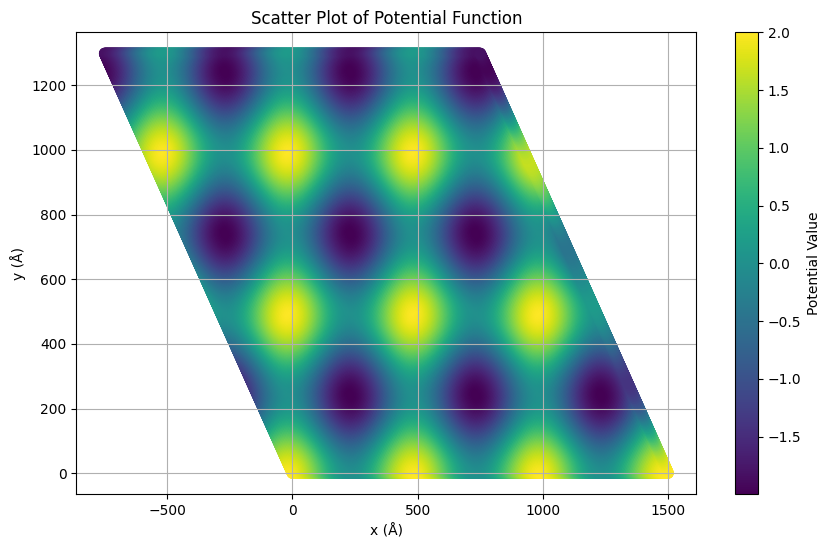

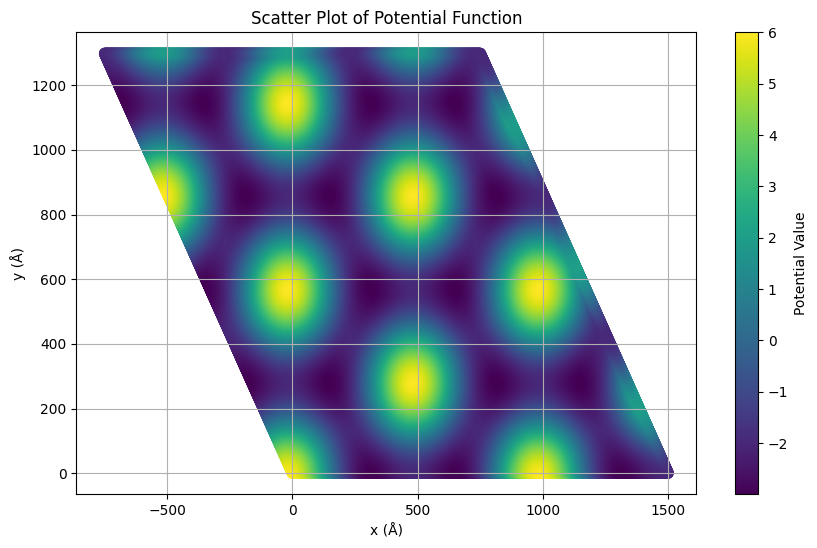

In [14]:
# Usage example
poscar_file = "bilayer_graphene/structures/standard_bilayer_graphene_AB.vasp"
L = 500.0
V0 = 1
tol = 1

simulation = Simulation(poscar_file, L, V0, tol)
simulation.run()
